# Load libs

In [22]:
import geopandas as gpd
from shapely.ops import unary_union
import pandas as pd
import pgeocode
import matplotlib as plt

In [ ]:
# Load the GeoJSON file
communes = gpd.read_file('data/communes4326.geojson')

In [ ]:
# Group by 'CANTON' and merge the polygons
cantons = communes.dissolve(by='CANTON', aggfunc='sum')

In [ ]:
# Save the result to a new GeoJSON file
cantons.to_file('data/cantons.geojson', driver='GeoJSON')

In [ ]:
# Group by 'DISTRICT' and merge the polygons
districts = communes.dissolve(by='DISTRICT', aggfunc='sum')

In [ ]:
# Save the result to a new GeoJSON file
districts.to_file('data/district.geojson', driver='GeoJSON')

In [ ]:
# Merge all the polygons in communes to create a single polygon for the country
country = gpd.GeoDataFrame(geometry=[unary_union(communes.geometry)], crs=communes.crs)

In [ ]:
# Save the result to a new GeoJSON file
country.to_file('lux.geojson', driver='GeoJSON')

## WWTP

In [13]:
# 1. Load the communes geoJSON
communes = gpd.read_file("./data/luxembourg-communes.geojson")

In [14]:
# 2. Load your Excel file with WWTP and Locality columns
mapping = pd.read_csv("data/Code_postal_par_STEP_merged 20230517.csv")

In [15]:
# 3. Merge: join communes and mapping on Locality name
# Make sure the column names match. For instance:
# In geojson: communes['locality'] or communes['name']
# In Excel: mapping['Locality']
communes['name'] = communes['name'].str.lower().str.strip()
mapping['Locality'] = mapping['Locality'].str.lower().str.strip()

In [16]:
# 4. Merge using the 'name' field from communes and 'Locality' from mapping
merged = communes.merge(mapping, left_on="name", right_on="Locality", how="inner")

In [17]:
# 5. Dissolve by WWTP to merge all polygons of each WWTP into one shape
dissolved = merged.dissolve(by="WWTP", as_index=False)

In [18]:
# 6. Save output to GeoJSON
dissolved.to_file("./data/wwtp_catchments.geojson", driver="GeoJSON")

print("✅ Done! The WWTP catchment areas GeoJSON has been created.")

✅ Done! The WWTP catchment areas GeoJSON has been created.


In [19]:
# Load country boundary GeoJSON
country = gpd.read_file("data/lux.geojson")

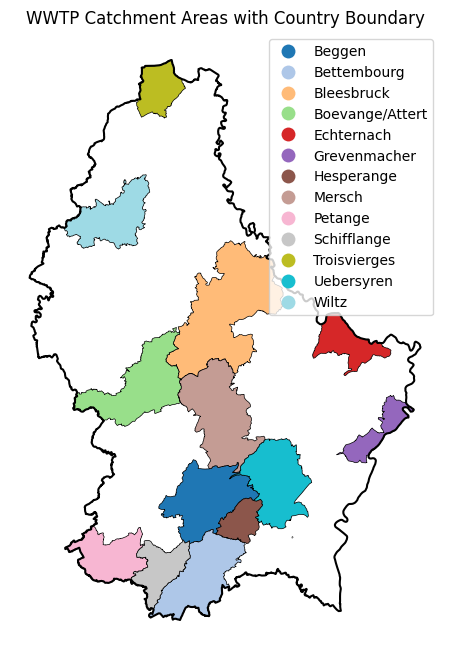

In [28]:
import matplotlib.pyplot as plt

# Plot both
fig, ax = plt.subplots(figsize=(12, 8))

# Plot WWTP catchments in color
dissolved.plot(ax=ax, column='WWTP', cmap='tab20', legend=True, edgecolor='black', linewidth=0.5)

# Overlay country boundary in bold black
country.boundary.plot(ax=ax, color='black', linewidth=1.5)

plt.title("WWTP Catchment Areas with Country Boundary")
plt.axis("off")
plt.show()

### plot zip code

for certififcate issue

In [3]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [4]:
# Load CSV with WWTP and zip codes
zip_data = pd.read_csv("data/Code_postal_par_STEP_merged 20230517.csv")

In [5]:
# Initialize pgeocode for Luxembourg (country code = 'LU')
nomi = pgeocode.Nominatim('LU')

In [ ]:
# Get coordinates for each unique postal code
unique_zips = zip_data['Code postal'].unique()

In [29]:
# Load the geojson and the CSV
addresses = gpd.read_file('./data/addresses.geojson')

In [30]:
mapping['Code postal'] = mapping['Code postal'].astype(str)

In [34]:
# Create an empty list to store the coordinates
zip_coordinates = []

# Iterate over unique zip codes in the CSV
for zip_code in mapping['Code postal'].unique():
    # Find the address in the geojson file matching the zip code
    matched_address = addresses[addresses['code_postal'] == zip_code]
    
    if not matched_address.empty:
        # Get the coordinates (longitude, latitude) for the first matched address
        coordinates = matched_address.geometry.iloc[0].coords
        longitude, latitude = list(coordinates)[0]
        
        # Append the result to the list
        zip_coordinates.append({
            'postal_code': zip_code,
            'latitude': latitude,
            'longitude': longitude
        })

# Convert to DataFrame
zip_coordinates_df = pd.DataFrame(zip_coordinates)


In [33]:
print(addresses.columns)

Index(['rue', 'numero', 'localite', 'code_postal', 'id_caclr_rue',
       'id_caclr_bat', 'id_geoportail', 'commune', 'lau2', 'geometry'],
      dtype='object')


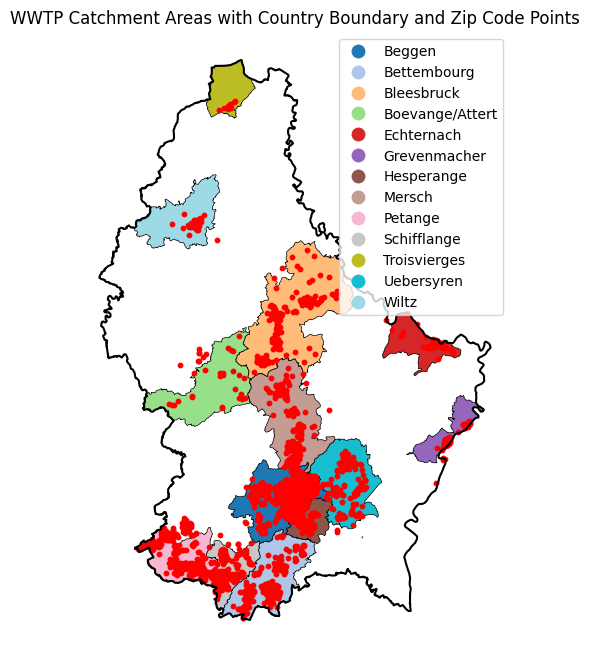

In [36]:
# Plot both
fig, ax = plt.subplots(figsize=(12, 8))

# Plot WWTP catchments in color
dissolved.plot(ax=ax, column='WWTP', cmap='tab20', legend=True, edgecolor='black', linewidth=0.5)

# Overlay country boundary in bold black
country.boundary.plot(ax=ax, color='black', linewidth=1.5)

# Plot the zip code points (from the coordinates DataFrame)
zip_points = gpd.GeoDataFrame(
    zip_coordinates_df, 
    geometry=gpd.points_from_xy(zip_coordinates_df.longitude, zip_coordinates_df.latitude),
    crs="EPSG:4326"
)

# Plot the points
zip_points.plot(ax=ax, color='red', markersize=10, label='Zip Code Points')

# Add a legend and title
# plt.legend()
plt.title("WWTP Catchment Areas with Country Boundary and Zip Code Points")
plt.axis("off")

plt.show()
